# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Наша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import seaborn as sns

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; <style>}"))
data = pd.read_csv('E:/BuduBogatym/real_estate_data.csv', sep ='\t')
pd.set_option('display.max_columns', None)

C:\Users\Naix3\AppData\Local\Temp\ipykernel_12068\19091388.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

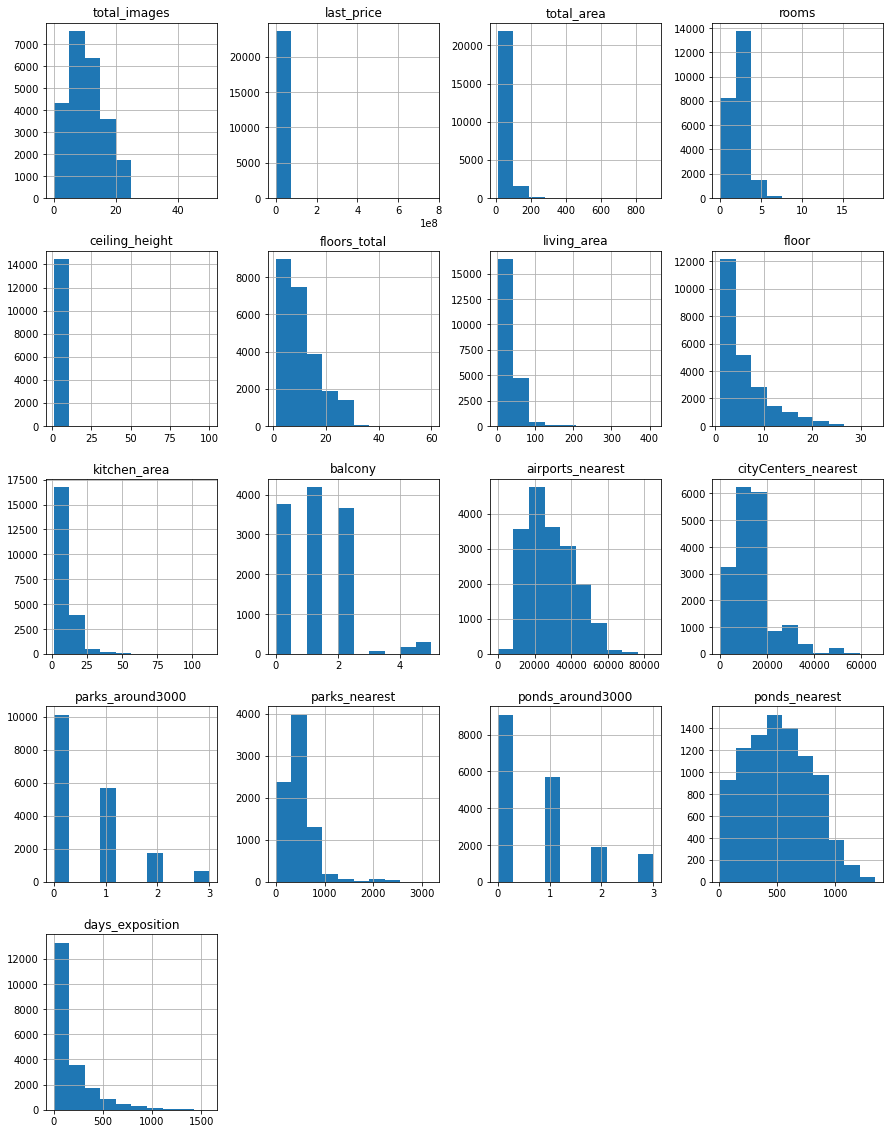

In [4]:
data.hist(figsize=(15, 20));# Построение гистограмм для всех столбцов

### Предобработка данных

In [5]:
data.isna().sum()#выведем на экран количество пропусков в каждом столбце

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [6]:
data.loc[data['balcony'].isna(),'balcony'] = 0# Заменим пропуски в графе "Балкон" на нули.
data.loc[data['is_apartment'].isna(),'is_apartment'] = False # укажем во всех пропусках апартаментов False.
data.loc[data['kitchen_area'].isna(),'kitchen_area'] = data['kitchen_area'].median()# Добавлены медианные значения в столбец с площодью кухни.
data.loc[data['ceiling_height'].isna(),'ceiling_height'] = data['ceiling_height'].median()# Добавлены медианные значения в столбец с высотой потолков.
data.dropna(subset = ['locality_name'] , inplace = True)# Избавимся от пропусков в locality_name.
data.isna().sum() # Проверка заполненных пропусков

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total               85
living_area              1898
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5534
cityCenters_nearest      5511
parks_around3000         5510
parks_nearest           15586
ponds_around3000         5510
ponds_nearest           14565
days_exposition          3180
dtype: int64

**Возможные причины возникновения пропусков в стобцах:**


    
* `ceiling_height` - Высоту потолков банально можно не иметь возможности измерить, либо же не предавать этому параметру значения, так как от него, скорее всего, мало что зависит. 

* `floors_total` - Общее количество этажей в доме могло быть пропущено случайно, так как пропусков крайне мало. Также этому параметру могли просто не предать значения, так как он редко имеет значение. 

* `living_area` - Причиной пропусков может быть только отсутствие информации о площади квартиры у владельца.

* `is_apartment` - Количество пропусков говорит о том, что просто никто не продаёт апартаменты в большинстве случаев и пропускают данный пункт.     
* `kitchen_area` - Количество пропусков около 13-15%, поэтому причиной может быть незнание истинной площади кухни людьми.     

* `balcony` - Причина пропусков - люди при отсутствии балкона просто не заполняют данный пункт.        

* `locality_name` - Скорее всего, причиной пропусков стала невнимательность человека при указании данных.    

* `airports_nearest` - Причиной может служить отсутствие аэропорта в данных городах или посёлках, так как данные являются картографическими, то они отсутствуют.     

* `cityCenters_nearest`, `parks_around3000`, `parks_nearest`, `ponds_around3000`, `ponds_nearest` - Данные столбцы имеют картографические данные, поэтому пропуски в них возникают из-за отсутствия таких данных у системы.    

* `days_exposition` - Причиной пропусков данного столбца, скорее всего, стали какие-либо технические проблемы, так как дата выставления и снятия объявления явно выставляется автоматически.     

 **Заменим тип данных в необходимых столбцах:**

In [7]:
data['is_apartment'] = data['is_apartment'].astype('bool')# Перевод столбца в булевое значение.
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')# Перевод object в datetime.


    
* Перевод столбца `is_apartment` в тип данных `bool` необходим по условию того, что он содержал значения `True` и `False`, то есть они отвечали на вопрос как `Да` или `Нет`.
* Перевод столбца `first_day_exposition` в тип данных `datetime` связан с тем, что в столбце была указана дата с неверным типом данных.

**Займёмся поиском дубликатов:**

In [8]:
print('Количество явных дубликатов:', data.duplicated().sum())# Поиск явных дубликатов

Количество явных дубликатов: 0


In [9]:
print(data['locality_name'].unique())# Посмотрим уникальные значения в locality_name

['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'поселок Мурино'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой'
 'посёлок городского типа Лебяжье' 'посёлок городского типа Сиверский'
 'поселок Молодцово' 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'посёлок Аннино' 'поселок городского типа Ефимовский'
 'посёлок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'посёлок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'посёлок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольское'
 'Зеленогорск' 'Сосновый Бор' 'поселок Новый Све


Проанализировав список данных уникальных значений, можно сделать вывод, что все дубликаты связаны с посёлками. Для решения данного вопроса создадим функцию, которая будет менять название на необходимое нам для дальнейшей корректной работы с данными.

In [10]:
def change_name(name):
    if 'поселок' in name or 'посёлок' in name:
        return 'посёлок ' + name.split()[-1] # меняем название на "посёлок"+"имя собственное"
    else:
        return name # Оставляем исходное название


    
Заменим неявные дубликаты, применив функцию `change_name`.

In [11]:
data['locality_name'] = data['locality_name'].apply(change_name)

display(data.head(20))# Проверим результат выполненной функции.


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07,3,2.70,16.0,51.00,8,False,False,False,25.00,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04,1,2.65,11.0,18.60,1,False,False,False,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20,2,2.65,5.0,34.30,4,False,False,False,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24,3,2.65,14.0,NaN,9,False,False,False,9.10,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19,2,3.03,14.0,32.00,13,False,False,False,41.00,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10,1,2.65,12.0,14.40,5,False,False,False,9.10,0.0,посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02,1,2.65,26.0,10.60,6,False,False,False,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18,2,2.65,24.0,NaN,22,False,False,False,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23,1,2.65,27.0,15.43,26,False,False,False,8.81,0.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26,3,2.50,9.0,43.60,7,False,False,False,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


**Устраним аномальные значения в имеющихся данных:**

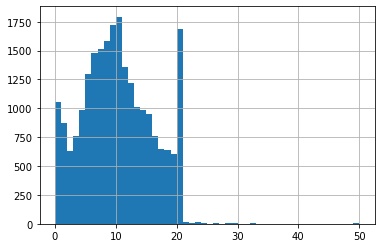

In [12]:
data['total_images'].hist(bins=50);

In [13]:
data = data.loc[(data['total_images'] < 25) & (data['total_images'] != 0)]
# Уберём из данных строки с аномально болшим или маленьким числом фотографий квартиры.

[ 2.7   2.65  3.03  2.5   2.67  2.56  3.05  2.75  2.6   2.9   2.8   2.55
  3.    3.2   2.61  3.25  3.45  2.77  2.85  2.64  2.57  4.15  3.5   3.3
  2.71  4.    2.47  2.73  2.84  3.1   2.34  3.06  2.72  2.54  2.51  2.78
  2.76 25.    2.58  3.7   2.52  5.2   2.87  2.66  2.59  2.    2.45  3.6
  3.4   2.92  3.11  3.13  3.8   3.15  3.55  3.16  3.62  3.12  2.53  2.74
  2.96  2.46  5.3   5.    2.79  2.95  4.06  2.94  3.82  3.54  3.53  2.83
  4.7   2.4   3.38  3.01  5.6   3.65  3.9   3.18  3.35  2.3   3.57  2.48
  2.62  2.82  3.98  2.63  3.83  3.52  3.95  3.75  2.88  3.67  3.87  3.66
  3.85  3.86  4.19  4.8   4.5   4.2   3.36 32.    3.08  3.68  3.07  3.37
  3.09  8.    3.26  3.34  2.81  3.44  2.97  3.14  4.37  2.68  3.22  3.27
 27.    4.1   2.93  3.46  3.47  3.33  3.63  3.32 26.    1.2   8.3   2.98
  3.24  2.86  3.17  4.4   3.28  3.04  4.45  5.5   3.84  3.23  3.02  3.21
  3.43  3.78  4.3   2.69  3.31  4.65  3.56  2.2   3.51  3.93  3.42  2.99
  3.49 14.    4.14  2.91  3.88  1.75  4.25  3.29 20. 

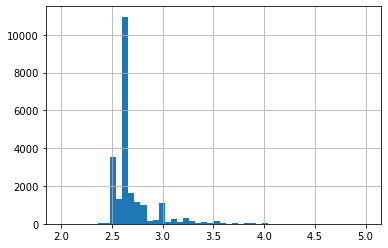

In [14]:
print(data['ceiling_height'].unique())
data['ceiling_height'].hist(bins=50 , range = (2,5));

Избавимся от слишком маленьких и больших значений высоты потолка.

In [15]:
data = data[(data['ceiling_height'] < 8) & (data['ceiling_height'] > 2)]

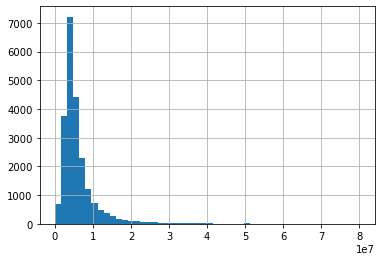

In [16]:
data['last_price'].hist(bins=50 , range = (0,80000000));

Избавимся от слишком высокой стоимости жилья, тем более, что таких объявлений крайне мало.

In [17]:
data = data[(data['last_price'] < 40000000)]

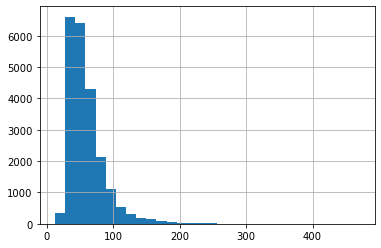

In [18]:
data['total_area'].hist(bins = 30);

Удалим часть крайне маленький значений площади 

In [19]:
data = data[data['total_area'] > 16]

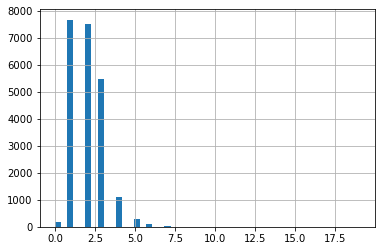

In [20]:
data['rooms'].hist(bins = 50);

Исключим объявления с большим числом комнат.

In [21]:
data = data[data['rooms'] < 10]


    
**В результате обработки, объём данных уменьшился на 5,82 %**

### Посчитайте и добавьте в таблицу новые столбцы

In [22]:
data['price_m2'] = data['last_price'] / data['living_area'] # Цена квадратного метра
data['publication_day'] = data['first_day_exposition'].dt.weekday # День публикации
data['publication_month'] = data['first_day_exposition'].dt.month # Месяц публикации
data['publication_year'] = data['first_day_exposition'].dt.year # Год публикации
data['km_to_center'] = round(data['cityCenters_nearest'] / 1000)# Расстояние до центра в километрах

In [23]:
data['type_floor'] = data['floor'].where(data['floor'] != data['floors_total'], 'последний')# заполним столбец только с последними этажами.
def floor_type(string):# функция определения типа этажа
    if string == 1:
        return 'первый'
    elif string == 'последний':
        return 'последний'
    else:
        return 'Другой'

Применим функцию к имеющемуся столбцу с последними этажами.

In [24]:
data['type_floor'] = data['type_floor'].apply(floor_type)

In [25]:
display(data.head())# Проверка правильности добавления столбцов.

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_m2,publication_day,publication_month,publication_year,km_to_center,type_floor
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,False,False,25.0,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,254901.960784,3,3,2019,16.0,Другой
1,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.6,1,False,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,180107.526882,1,12,2018,19.0,первый
2,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.3,4,False,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,151486.880466,3,8,2015,14.0,Другой
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,False,False,41.0,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,312500.000000,1,6,2018,8.0,Другой
5,10,2890000.0,30.4,2018-09-10,1,2.65,12.0,14.4,5,False,False,False,9.1,0.0,посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0,200694.444444,0,9,2018,NaN,Другой


**Вывод:** В данном пункте были добавлены дополнительные столбцы с новой информацией, необходимой для дальнейшнего исследования.

### Проведите исследовательский анализ данных


    
**Построим гистограммы для данных параметров:**
  - общая площадь;
  - жилая площадь;
  - площадь кухни;
  - цена объекта;
  - количество комнат;
  - высота потолков;
  - этаж квартиры;
  - тип этажа квартиры («первый», «последний», «другой»);
  - общее количество этажей в доме;
  - расстояние до центра города в метрах;
  - расстояние до ближайшего аэропорта;
  - расстояние до ближайшего парка;
  - день и месяц публикации объявления

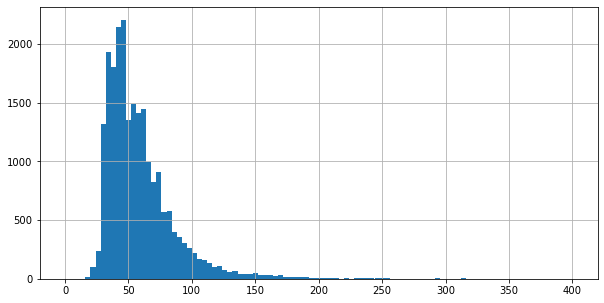

In [26]:
data['total_area'].hist(bins = 100 , range = (0, 400), figsize = (10, 5));# Гистограмма общей площади

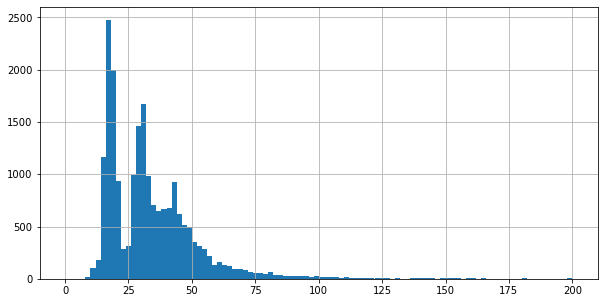

In [27]:
data['living_area'].hist(bins = 100 , range = (0, 200), figsize = (10, 5));# Гистограмма жилой площади

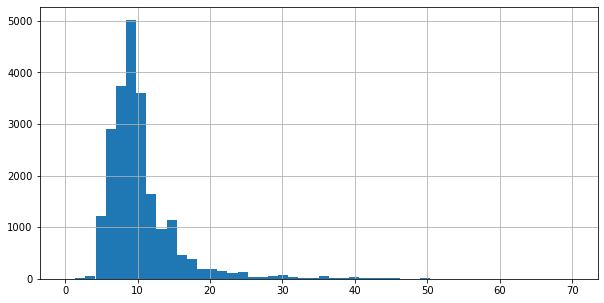

In [28]:
data['kitchen_area'].hist(bins = 50 , range = (0, 70), figsize = (10, 5));# Гистограмма площади кухни

Максимальная цена: 39990000.0


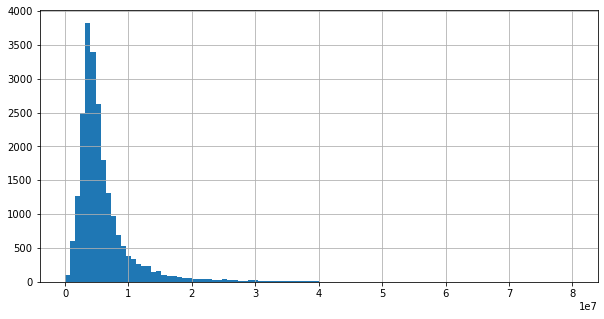

In [29]:
print('Максимальная цена:', data['last_price'].max())
data['last_price'].hist(bins = 100 , range = (0, 80000000), figsize = (10, 5));# Гистограмма стоимости квартиры

Максимальное число комнат: 9


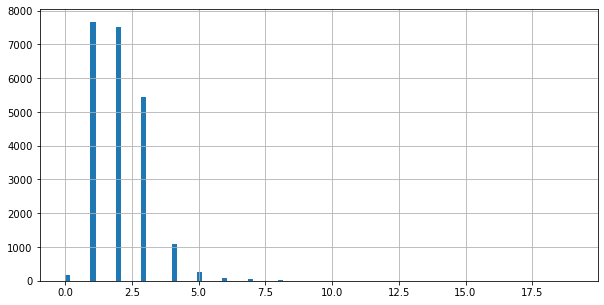

In [30]:
print('Максимальное число комнат:', data['rooms'].max())
data['rooms'].hist(bins = 100 , range = (0, 19), figsize = (10, 5));# Гистограмма количества комнат

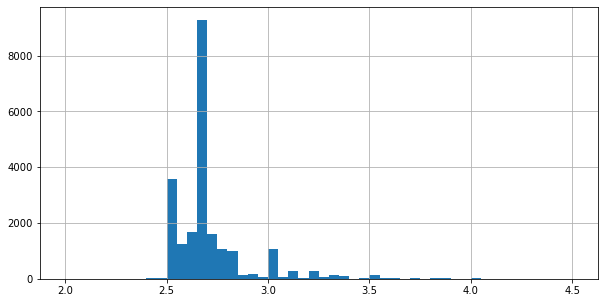

In [31]:
data['ceiling_height'].hist(bins = 50 , range = (2, 4.5), figsize = (10, 5));# Гистограмма высоты потолков

Максимальный этаж: 33


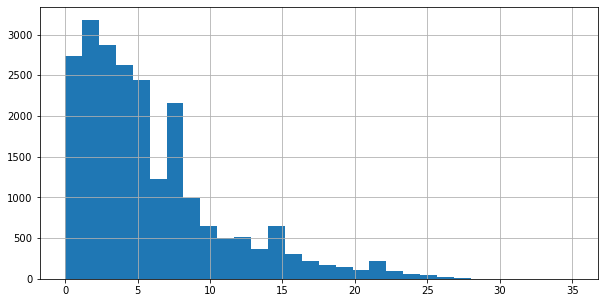

In [32]:
print('Максимальный этаж:', data['floor'].max())
data['floor'].hist(bins = 30 , range = (0, 35), figsize = (10, 5));# Гистограмма этажа

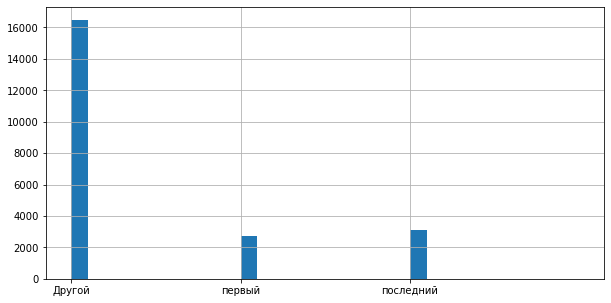

In [33]:
data['type_floor'].hist(bins = 30 , range = (0, 3), figsize = (10, 5));# Гистограмма типа этажа

Самое высокое здание 60.0


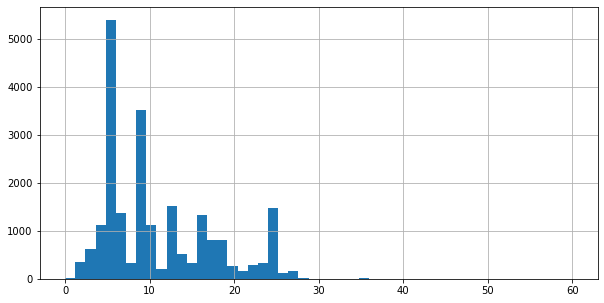

In [34]:
print('Самое высокое здание', data['floors_total'].max())
data['floors_total'].hist(bins = 50 , range = (0, 60), figsize = (10, 5));# Гистограмма высоты домов

Наибольшее расстояние до центра 65968.0


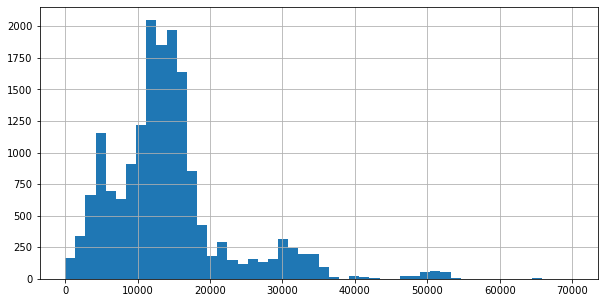

In [35]:
print('Наибольшее расстояние до центра', data['cityCenters_nearest'].max())
data['cityCenters_nearest'].hist(bins = 50 , range = (0, 70000), figsize = (10, 5));# Гистограмма расстояния до центра

Наибольшее расстояние до аэропорта 84869.0


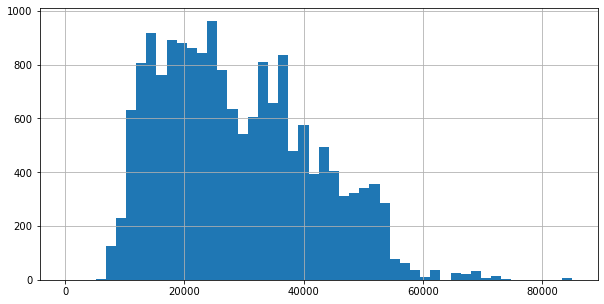

In [36]:
print('Наибольшее расстояние до аэропорта', data['airports_nearest'].max())
data['airports_nearest'].hist(bins = 50 , range = (0, 85000), figsize = (10, 5));# Гистограмма расстояния до аэропорта

Наибольшее расстояние до парка 3190.0


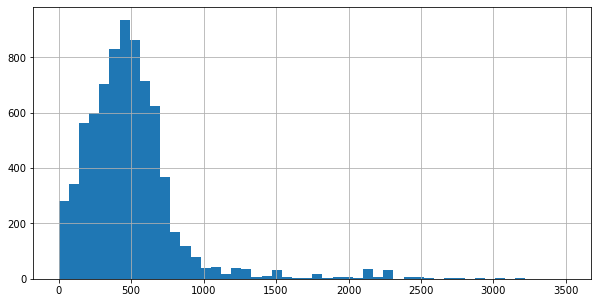

In [37]:
print('Наибольшее расстояние до парка', data['parks_nearest'].max())
data['parks_nearest'].hist(bins = 50 , range = (0, 3500), figsize = (10, 5));# Гистограмма расстояния до парка

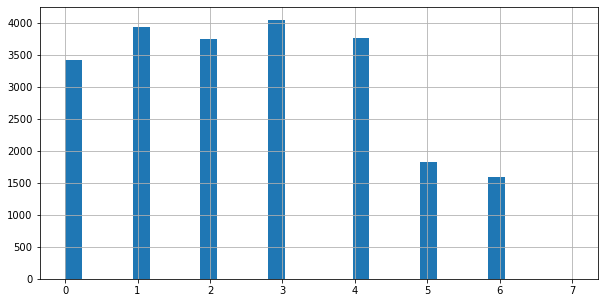

In [38]:
data['publication_day'].hist(bins = 30 , range = (0, 7), figsize = (10, 5));# Гистограмма дней недели

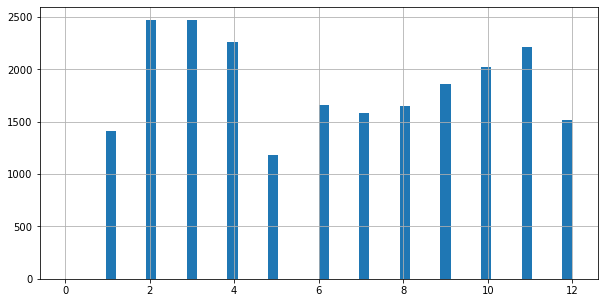

In [39]:
data['publication_month'].hist(bins = 50 , range = (0, 12), figsize = (10, 5));# Гистограмма месяцев в году


    
**Опишем все гистограммы, полученные в ходе иследдования, по данным параметрам:**
  - **общая площадь** - Гистограмма данного параметра форму распределения Пуассона, можно заменить, что большинство квартир приходит на 45-70 квадратных метров, то есть это 2-ух или 3-х комнатные квартиры.
  - **жилая площадь** - На данной гистограмме имеются некоторые всплески, предполагаю, что это стандартные 1,2 или 3-х комнатные квартиры, которые более доступны для среднестатистического человека, поэтому их и больше всего.
  - **площадь кухни** - Как и предыдущих гистограммах здесь можно заметить всплеск значений на определенном значении площади кухни, вероятно, что это значение стандартной площади кухни для более распространенных квартир.
  - **цена объекта** - Гистограмма стоимости квартиры имеет аналогичное с вышеперечисленными параметрами распределение, которое сначала растёт до более распространённых квартир (1 или 2-х комнатных), а далее с увеличением цены происходит резкое падение количества объявлений.
  - **количество комнат** - По данной гистограмме можно проследить , что действительно 1-3х комнатные квартиры являются наиболее распространёнными и составляют огромнейшую часть объявлений. 
  - **высота потолков** - В большинстве случаев прослеживается потолок в 2.7 метра, который является стандартной высотой потолков в России, остальные же значения являются какими-либо редкими исключениями.
  - **этаж квартиры** - Исходя из гистограммы выходит, что наибольшее число объявлений на 2-6 этажах, это можно аргументировать тем, что в посёлках, деревнях и региональных городах преобладают низкие здания.
  - **тип этажа квартиры** - Очевидно, что "первый" и "последний" будут иметь меньшее число объявлений, так как остальных этажей явно больше в преобладающем числе домов (кроме 2-х и 3-х этажных построек).
  - **общее количество этажей в доме** - Данная гистограмма показывает, что наибольшее число объявлений поступает из 5, и 9-ти этажных домов, которые наиболее распространены в большинстве городов страны, однако можно проследить резкие всплески на более высоких значениях, что свидетельстует о большом количестве высоких построек в крупнейших городах России.
  - **расстояние до центра города в метрах** - Гистограмма также имеет распределение Пуассона, по которому можно сделать вывод, что большая часть квартир находится от центра города на расстоянии 10-18 км.
  - **расстояние до ближайшего аэропорта** - Несмотря на изменяющееся расстояние, гистограмма не имеет резких всплесков, что свидетельствует о том, что аэропорты в разных городах находятся на прапорциональном расстоянии от местоположений квартир. То есть чем больше город, тем выше расстояние до центра и наоборот, поэтому распределение имеет более или менее ровный участок.
  - **расстояние до ближайшего парка** - В большинстве случаев парк располагается на расстоянии в 400-800 метров
  - **день и месяц публикации объявления** - Гистограмма по дням показывает, что большинство объявлений выставлено в буднии дни, так как чаще всего с продажей помогают риэлторы, которые работаю по будням. Что касается месяца года, то можно сделать вывод, что люди реже ставят объявления в Январе (Новый Год как никак), в мае (возможно все на дачах сажают картошку). Пик объявлений приходит на начало весны, возможно, это связано с потеплением и желанием действовать активнее после холодной зимы.

**Построим гистограмму, демонстрирующую скорость продажи квартир:**

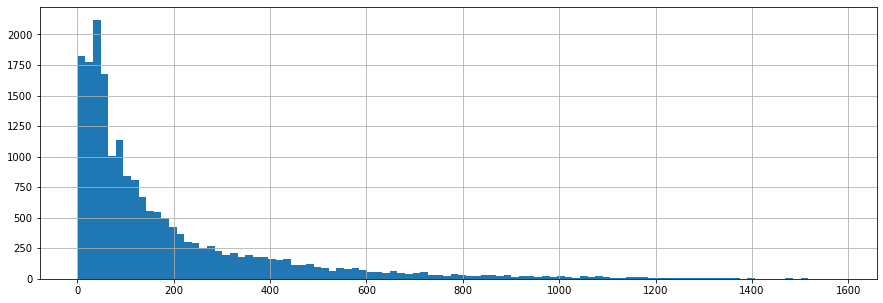

In [40]:
data['days_exposition'].hist(bins = 100 , figsize = (15, 5));

In [41]:
print('Среднее значение скорости продаж:', data['days_exposition'].mean())
print('Медианное значение скорости продаж:', data['days_exposition'].median())

Среднее значение скорости продаж: 181.66
Медианное значение скорости продаж: 97.0



    
Анализируя среднее и медианное значение, можно прийти к выводу, что жильё, которое продали менее чем за *98* дней - можно считать быстропроданным, а жильё, проданное несколько дольше чем за *182* дня - считать долгопродающимися.

**Определим, какие факторы больше всего влияют на стоимость жилья:**

коэффициент корреляции: 0.7845658324662143


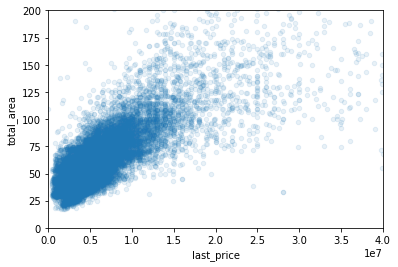

In [42]:
print('коэффициент корреляции:', data['last_price'].corr(data['total_area']))
data.plot(x='last_price', y='total_area', kind='scatter', xlim=(0, 40000000), ylim = (0, 200) , alpha = 0.1); 

В данном случае можно проследить высокую зависимость стоимости жилья от общей площади.

коэффициент корреляции: 0.6895127016891023


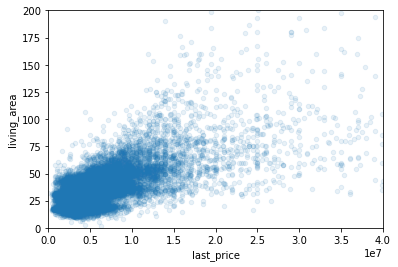

In [43]:
print('коэффициент корреляции:', data['last_price'].corr(data['living_area']))
data.plot(x='last_price', y='living_area', kind='scatter',xlim=(0, 40000000), ylim = (0, 200), alpha=0.1);

У цены жилья и жилой площади также заметный уровень зависимости.

коэффициент корреляции: 0.5696424085179114


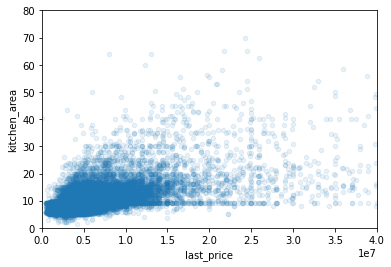

In [44]:
print('коэффициент корреляции:', data['last_price'].corr(data['kitchen_area']))
data.plot(x='last_price', y='kitchen_area', kind='scatter',xlim=(0, 40000000), ylim = (0, 80), alpha=0.1);

Стоимость жилья и площадь кухни имеет заметную зависимость друг от друга

,last_price
rooms,
0,2.999588e+06
1,3.840655e+06
2,5.524841e+06
3,7.663758e+06
4,1.097479e+07
5,1.485969e+07
6,1.875804e+07
7,2.110449e+07
8,2.274333e+07


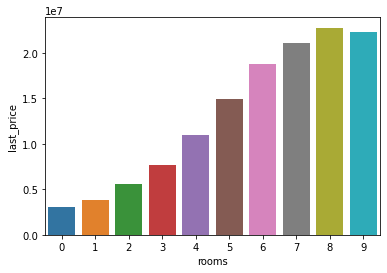

In [45]:
pivot_rooms = data.pivot_table(index = 'rooms', values = 'last_price', aggfunc = 'mean')
display(pivot_rooms)
sns.barplot(x = pivot_rooms.index, y = pivot_rooms['last_price']);

Прекрасно видно, что цена жилья явно зависит от числа комнат, что логично. Хотя странно, что 9-комнатные квартиры в среднем дешевле.

,last_price
type_floor,
Другой,6.160596e+06
первый,4.643006e+06
последний,5.756791e+06


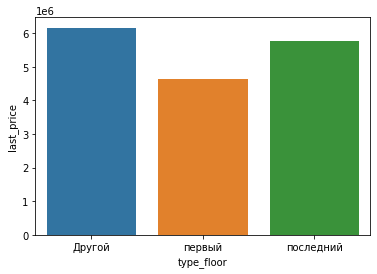

In [46]:
pivot_floor = data.pivot_table(index = 'type_floor', values = 'last_price', aggfunc = 'mean')
display(pivot_floor)
sns.barplot(x = pivot_floor.index, y = pivot_floor['last_price']);

Здесь можно проследить, что наибольшее значение имеет параметр "Другой", а наименьшая стоимость квартир на первом этаже

,last_price
publication_day,
0,5.943368e+06
1,5.854167e+06
2,6.054324e+06
3,6.113053e+06
4,5.787040e+06
5,5.668556e+06
6,5.819196e+06


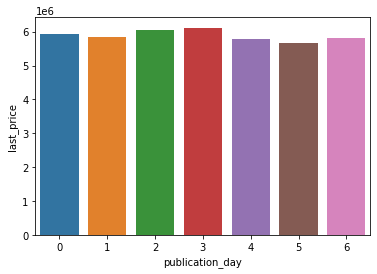

In [47]:
pivot_pubDay = data.pivot_table(index = 'publication_day', values = 'last_price', aggfunc = 'mean')
display(pivot_pubDay)
sns.barplot(x = pivot_pubDay.index, y = pivot_pubDay['last_price']);

По данной столбчатой диаграмме можно сделать вывод, что стоимость жилья никак не зависит от дня публикации объявления.

,last_price
publication_month,
1,6.084684e+06
2,5.897317e+06
3,5.879602e+06
4,5.839618e+06
5,5.983075e+06
6,5.743036e+06
7,5.895771e+06
8,6.022199e+06
9,6.020844e+06


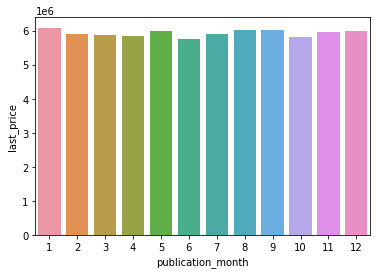

In [48]:
pivot_pubMonth = data.pivot_table(index = 'publication_month', values = 'last_price', aggfunc = 'mean')
display(pivot_pubMonth)
sns.barplot(x = pivot_pubMonth.index, y = pivot_pubMonth['last_price']);

В данном случае никакой явной зависимости не прослеживается, так что можно сделать вывод, что стоимость не зависит от месяца публикации.

,last_price
publication_year,
2014,9.846720e+06
2015,7.007298e+06
2016,5.965085e+06
2017,5.830491e+06
2018,5.681011e+06
2019,6.231040e+06


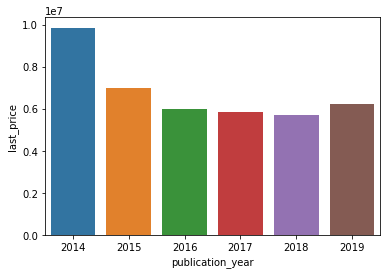

In [49]:
pivot_pubYear = data.pivot_table(index = 'publication_year', values = 'last_price', aggfunc = 'mean')
display(pivot_pubYear)
sns.barplot(x = pivot_pubYear.index, y = pivot_pubYear['last_price']);

По данной диаграмме наблюдается падение стоимости жилья после 2014 года, можно заметить лишь небольшой рост в 2019 году.

**Вывод:** По результатам построения столбчатых диаграмм и диаграмм рассеяния можно прийти к выводу, что в первую очередь цена на жильё в большей степени зависит от следующих параметров:
 * Общая площадь квартиры
 * Количество комнат



**Расчёт средней цены одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений:**

,number_of_ads,price_m2
locality_name,,
Санкт-Петербург,14826,208143.497836
посёлок Парголово,316,200415.479888
Пушкин,345,193821.724020
деревня Кудрово,279,189519.917362
посёлок Мурино,538,174885.566865
посёлок Шушары,419,157209.922983
Всеволожск,385,134380.587614
Колпино,297,132796.257301
Гатчина,294,120789.641684


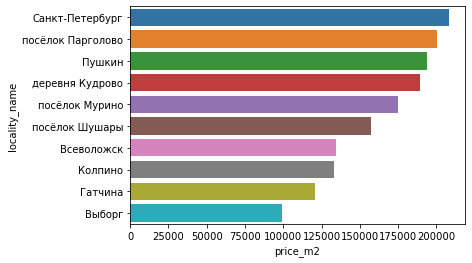

In [50]:
data_top = data.pivot_table( index = 'locality_name', values = 'total_images', aggfunc = 'count')# Подсчёт количества объявлений.
data_top.columns = ['number_of_ads'] # Смена названия столбца на более целесообразный.
data_top10 = data_top.sort_values(by = 'number_of_ads',ascending=False).head(10) # Топ 10 количество объявлений
data_sqr = data.pivot_table(index = 'locality_name', values = 'price_m2', aggfunc = 'mean') # Таблица со средним значением цены за квадратный метр по городам.
data_top10 = data_top10.merge(data_sqr , on = 'locality_name').sort_values(by = 'price_m2', ascending=False) # Объединим две таблицы в одну
display(data_top10)
sns.barplot(x = data_top10['price_m2'], y = data_top10.index);

По данной столбчатой диаграмме можно сделать вывод, что самый дорогой квадратный метр находится в Санкт-Петербурге (что логично), а вот самый дешевый квадратный метр в Выборге.

Коэффициент корреляции: -0.41131128096071967


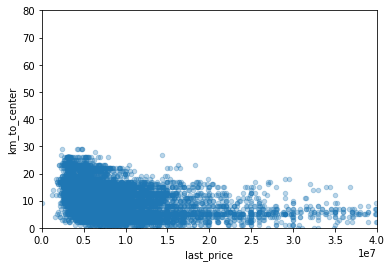

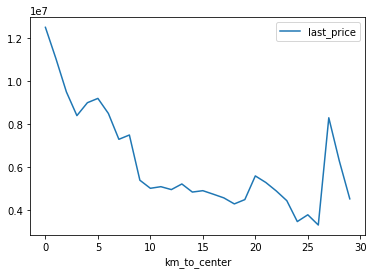

In [51]:
data['price_km'] = data['last_price'] / data['km_to_center'] # Найдём цену за километр до центра города
data_spb = data[data['locality_name'] == 'Санкт-Петербург'] # Создадим датасет только с Санкт-Петербургом
print('Коэффициент корреляции:', data_spb['last_price'].corr(data_spb['km_to_center']))
data_spb.plot(x='last_price', y='km_to_center', kind='scatter',xlim=(0, 40000000), ylim = (0, 80), alpha=0.3);
data_spb.pivot_table( index = 'km_to_center' , values = 'last_price' , aggfunc = 'median').plot();

Мы имеем умеренный коэффициент корреляции, что доказывает низкую зависимость между стоимостью жилья и расстоянием до центра, однако она всё же есть. Поэтому можно сделать вывод, что чем ближе жильё к центру, тем оно дороже, также можно предположить, что центр Санкт-Петербурга имеет радиус 7 - 8 км. Однако на графике зависимости медианной стоимости отбъектов от расстояния до центра можно заметить небольшой скачок между 25 и 30 км, предполагаю, что это может быть некоторое дорогое жилье в каком-то районе. В остальном же можно прослеживать закономерное падение стоимости квартир с увеличением расстояния.

### Общий вывод



В ходе данного исследования был проведён ряд мероприятий:  

<h6>Предобработка данных:</h6>
   
* Заменены пропуски в столбце с балконами на нулевые значения;
* Пропуски в площади кухни и высоты потолков заменены на медианное значение;
* Строки с отсутствующим названием населенного пункта были удалены;
* Были выявлены и устранены неявные дубликаты в базе данных;
* Преобразованы типы данных у даты и принадлежности к апартаментам;
* Устранены аномальные значения в столбцах с количеством картинок, высотой потолков, количеством комнат и общей площадью квартир; 
    
**Итог:** Была проведена предобработка данных для повышения достоверности исследования. Из первоначальной базы данных было удалено порядка **6%** данных.
    
<h6> Добавление новой информации: </h6>
    
* Были добавлены столбцы с километровым расстоянием до центра, с днём, месяцем, годом публикации объявления, типом этажа, стоимостью квадратного метра.
    
**Итог:** Добавлена новая информация в базу данных для дальнейшего её исследования.
    
<h6>Исследовательский анализ данных:</h6>
    
* Построены гистограммы, позволяющие сделать вывод о том, что стоимость жилья имеет зависимость от общей, жилой, кухонной площадей, а также от количества комнат в квартире. Выяснили, что стоимость жильзя не зависит от типа этажа, дня и месяца публикации, однако, начиная с 2015 года происходит резкое падение стоимости квартир, вероятно из-за кризиса 2014 года.  
    
* Были проанализированы 10 городов с наибольшим числом объявлений и вычислена стоимость квадратного метра, самым дорогим оказался Санкт-Петербург со значением в 208 тыс. рублей, а самым дешевым - Выборг, со значением в 99 тыс. рублей за квадратный метр жилья.

* Для Сантк-Петербурга был построен график зависимости медианного значения стоимости жилья в зависимости от расстояния до центра, при исследовании которого стало возможно сделать вывод о умеренной зависимости этих двух параметров друг от друга.  

**Итог:** Исследование позволило определить рыночную стоимость объектов недвижимости, также была построена автоматизированная система по отслеживанию аномалий и мошеннической деятельности.

